# Notebook 6: Ligand Binding, Conformational change and Linear Response theory

### Modeling ligand binding in the elastic network.

In this work shop we want to define a notion of allostery in our elastic networks. Before we do that we must defined what it means for elastic networks to bind ligand. In proteins, ligand binding acts as a perturbation at the binding sites. In our model we will represent the effect of ligand binding as an imposed displacement on few nodes on the exterior of the network.

Once this is done we need to compute the response of the rest of the network to the applied displacement. How does the rest of the network move? To do this we will need to do a linear response calculation.

In linear response, the force $F$ on each node that results from a displacement $\Delta r$ is given by,

$$F = H \Delta r$$



We are going to apply a displacement on a group of nodes (call them the binding site nodes) but leave the others to respond. Our linear response problem looks like this now,

$$ 
 \left(\begin{matrix}
f_a \\
f_r \\
\end{matrix}\right)
 = H 
\left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$

Where $\Delta r_a$ is the displacement we apply on the binding site nodes and $f_a$ is the resulting force on the binding site nodes. $\Delta r_r$ is the response displacement of the rest of the network and $f_r$ is the force on the rest of the nodes of the network. Since we are not constraining the nodes outside the binding site so we know the force on them is zero because they are at mechanical equilibrium. Our new equation is, 

$$ 
 \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
 = H 
\left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$


The known variable is $\Delta r_a$. The variables we need to solve for are $\Delta r_r$ and $f_c$. In order to solve matrix equation on the computer we need to get it in the form of,

$$ 
 \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
 = W
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
$$

where $W$ is a matrix, **Lets try to do this on the board!**





$$ 
\begin{align}
 \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
 &= H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
+ H 
\left(\begin{matrix}
0 \\
\Delta r_r \\
\end{matrix}\right)\\
I \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
- H 
\left(\begin{matrix}
0 \\
\Delta r_r \\
\end{matrix}\right)
&= H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)\\
B \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
&= H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right) \\
\left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
&= B^{-1}H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
\end{align}
$$

$$
 B_{ij} =
  \begin{cases}
   \delta_{ij} & \text{if $j \in $ binding site dimensions} \\
   -H_{ij} & \text{otherwise.} 
  \end{cases}
$$

In practice computing the inverse of a matrix is slow. We will actually solve the problem in the for $Ax=b$, which for us is,

$$
B \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
= H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right).
$$

In [24]:
using Revise, LinearAlgebra, PyPlot, LaTeXStrings, Statistics, BenchmarkTools
push!(LOAD_PATH, "../src/")
using Elastic_N3, Elastic_N4, Elastic_N5

### Build network

In [2]:
W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e1 # softest spring constant in interaction table
k_max = 1e-2 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);
H = computeHessian(r, S);

First lets pick some nodes to apply a displacment to.

In [4]:
bindingSiteNodes = [4,5,6,7]

4-element Vector{Int64}:
 4
 5
 6
 7

In [5]:
# get the idicies that correspond to  these nodes in the structure vector
site = sort([bindingSiteNodes * 2; bindingSiteNodes * 2 .- 1])

8-element Vector{Int64}:
  7
  8
  9
 10
 11
 12
 13
 14

Next, Let's generated a random diplament and normalize it.

In [6]:
Δr_a = randn(length(site))
normalize!(Δr_a)

8-element Vector{Float64}:
 -0.3712046025593357
  0.4252406617663667
 -0.13032412971952795
 -0.5989300033591932
 -0.20705927311536673
 -0.1899562413574747
 -0.3438713271170381
  0.32935025289396147

In [7]:
# check to see if it has unit length.
norm(Δr_a)

1.0

### Plot applied displacement on binding site nodes.

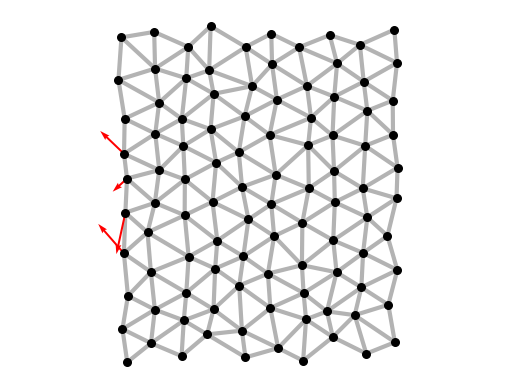

In [8]:
fig, ax = subplots()
plotNetwork!(ax,r, A)
plotDisplacment!(ax, r[site], Δr_a)

## Setting up the linear response calculation

#### 1: Make the vector

$$
c = \left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
$$

In [9]:
c = zeros(length(r))
c[site] = Δr_a
c

200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 -0.3712046025593357
  0.4252406617663667
 -0.13032412971952795
 -0.5989300033591932
 -0.20705927311536673
 -0.1899562413574747
 -0.3438713271170381
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

#### 2. Compute Matrix multiplication

$$
b = H 
\left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right) = H c
$$


In [25]:
@btime b = H * c

  6.053 μs (1 allocation: 1.77 KiB)


200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.016554890855460466
 -0.17470847575693638
 -1.3861996309796476
  1.5811947220622595
 -0.3181053471079167
 -0.7258623362115937
 -0.13336215071552232
  0.006375405895119174
 -0.5782583348103879
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

#### 3: Build $B$

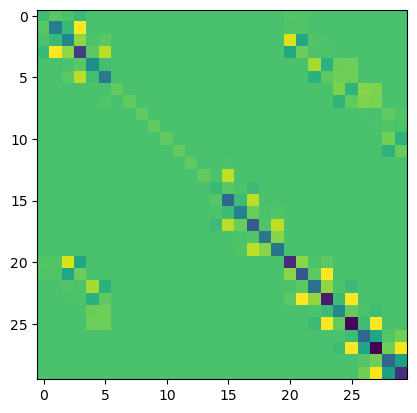

PyObject <matplotlib.image.AxesImage object at 0x16e87e350>

In [21]:
B = -H
B[:,site] .= I(length(r))[:,site];
imshow(B[1:30,1:30])

#### 4: Solve the linear problem
$$ x = \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)$$

$$ B x = b $$ 

In [26]:
# use the all powerful matrix div opporator: 
@btime x = inv(B) * b

  1.822 ms (6 allocations: 416.20 KiB)


200-element Vector{Float64}:
 -0.835288342456032
  0.23522179406878632
 -0.7001813922638445
  0.2547635892082732
 -0.6076558183204223
  0.24221590386833852
  0.06408031111253806
  0.7311884557369975
 -0.18702830957120734
 -0.7091869161633971
  0.2615383369629049
 -0.2670562418536089
 -0.1385903385042377
  ⋮
 -0.281722837785955
 -0.6423197039741193
 -0.18670341658709672
 -0.6454969595723679
 -0.08641294629551885
 -0.6318975968209772
  0.0200260676634538
 -0.6312238470459307
  0.1518331885209281
 -0.6461886141485995
  0.2593669925260527
 -0.6376471438958595

In [28]:
@btime x = B \ b 

  472.189 μs (4 allocations: 316.08 KiB)


200-element Vector{Float64}:
 -0.8352883424560309
  0.23522179406878624
 -0.7001813922638448
  0.2547635892082731
 -0.6076558183204223
  0.24221590386833872
  0.06408031111253853
  0.7311884557369972
 -0.18702830957120734
 -0.7091869161633971
  0.26153833696290507
 -0.26705624185360893
 -0.1385903385042379
  ⋮
 -0.28172283778595486
 -0.6423197039741176
 -0.18670341658709688
 -0.6454969595723665
 -0.08641294629551914
 -0.6318975968209761
  0.020026067663454807
 -0.6312238470459289
  0.15183318852092767
 -0.6461886141485981
  0.25936699252605216
 -0.637647143895858

#### 5: Make the force and displacement vectors, 

Currently you have,

$$ 
c =  \left(\begin{matrix}
\Delta r_a \\
0 \\
\end{matrix}\right)
\quad \text{and} \quad
x = \left(\begin{matrix}
f_a \\
\Delta r_r \\
\end{matrix}\right)
$$

But you need

$$ 
F =  \left(\begin{matrix}
f_a \\
0 \\
\end{matrix}\right)
\quad \text{and} \quad
\Delta r = \left(\begin{matrix}
\Delta r_a \\
\Delta r_r \\
\end{matrix}\right)
$$

In [31]:
# compute the force vector on all nodes
F = copy(c)
F[site] = x[site]
F

200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.06408031111253853
  0.7311884557369972
 -0.18702830957120734
 -0.7091869161633971
  0.26153833696290507
 -0.26705624185360893
 -0.1385903385042379
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [32]:
# compute diplacement vector of all nodes
Δr = copy(x)
Δr[site] = c[site]
Δr

200-element Vector{Float64}:
 -0.8352883424560309
  0.23522179406878624
 -0.7001813922638448
  0.2547635892082731
 -0.6076558183204223
  0.24221590386833872
 -0.3712046025593357
  0.4252406617663667
 -0.13032412971952795
 -0.5989300033591932
 -0.20705927311536673
 -0.1899562413574747
 -0.3438713271170381
  ⋮
 -0.28172283778595486
 -0.6423197039741176
 -0.18670341658709688
 -0.6454969595723665
 -0.08641294629551914
 -0.6318975968209761
  0.020026067663454807
 -0.6312238470459289
  0.15183318852092767
 -0.6461886141485981
  0.25936699252605216
 -0.637647143895858

#### 6: Compute the energy of "ligand Binding"

$$ E = F \cdot \Delta r$$

In [33]:
E = dot(F, Δr)

0.8612129139189904

#### 7: Wrap it all up into function

In [34]:
function computeResponse(r, H, strain, site)
    # Solve the linear response problem.

    # build vector (Δr_a, 0)
    c = zeros(length(r))
    c[site] = strain

    # multiply 
    b = H * c
    
    # build B matrix
    B = -H
    B[:,site] = I(size(B,1))[:,site]

    # solve linear problem
    x = B \ b 

    # get Force vector
    F = copy(c)
    F[site] = x[site]

    # get displacement vector
    Δr = copy(x)
    Δr[site] = c[site]

    # compute Energy
    E = dot(F, Δr)

    return E, F, Δr 
end

computeResponse (generic function with 1 method)

## Plot Response on network

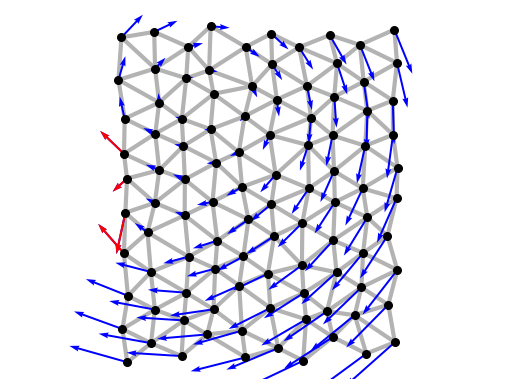

In [35]:
# show response on network
E, F, Δr  = computeResponse(r, H, Δr_a, site);

fig, ax = subplots()
plotNetwork!(ax,r, A)

# plot response
plotDisplacment!(ax,r, Δr, color="b")

# plot applied displacement
plotDisplacment!(ax,r[site], Δr_a, color="r")

It looks like we are seeing a lot of rotation and we can't see the under lying deformation. Let's remove the rotation and translation. Here are two functions to do this.

In [36]:
function getTranslationRotation(r)
    
    # r is a vector of positions r = (x1,y1,x2,y2,...)
    N = length(r)
    @assert iseven(N)
    n = Int(N/2)
    
    # move origin to center of mass
    xy = r2xy(r)
    x_mean, y_mean = mean(xy, dims=1)
    xy[:,1] .-= x_mean
    xy[:,2] .-= y_mean
    r = xy2r(xy)

    # compute x and y translations vector
    vx = normalize([ones(n) zeros(n)]'[:])
    vy = normalize([zeros(n) ones(n)]'[:])
    
    # compute rotation vector
    rotMat = [0 -1; 1 0]
    R = zeros(N, N)
    for i in 1:n
        R[2i-1:2i,2i-1:2i] = rotMat
    end
    vr = normalize(R * r)
    return [vx vy vr]
end

function removeTranslationRotation!(dr, r)
    # dr : applied displacement
    # r : postion vector

    V = getTranslationRotation(r)
    dr .-= V * V' * dr
    normalize!(dr)
    return nothing
end

removeTranslationRotation! (generic function with 1 method)

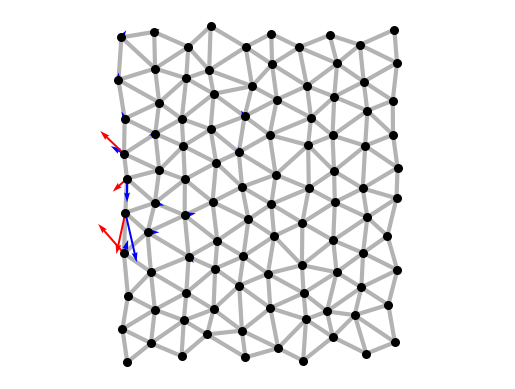

In [37]:
E, F, Δr  = computeResponse(r, H, Δr_a, site);

# Remove Translation and rotation.
removeTranslationRotation!(Δr, r)

fig, ax = subplots()
plotNetwork!(ax,r, A)

# plot response
plotDisplacment!(ax,r, Δr, color="b", scale=0.5)

# # plot applied displacement
plotDisplacment!(ax,r[site], Δr_a, color="r")

## Answers

In [ ]:
######################################################
# Answer to 1.

c = zeros(length(r))
c[site] = Δr_a

######################################################
# Answer to 2.
b = H * c

######################################################
# Answer to 3.
B = -H
B[:,site] = I(size(B,1))[:,site]
imshow(B[1:50, 1:50])

######################################################
# Answer to 4.

x = B \ b 